In [ ]:
pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 47kB/s 


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1h8O9j2bPYA9Pk82cMeezVsHoki4rOYpe'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Salinas_corrected.mat')

In [ ]:
downloaded = drive.CreateFile({'id':'1iTEtJA7tF_EovI6H0nlDjnYwR0PBZYaw'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Salinas_gt.mat')

In [ ]:
%load_ext tensorboard
import datetime, os

In [ ]:
!pip install -q keras
!pip install h5py ppyaml
!pip install spectral
import spectral

ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml
     |████████████████████████████████| 215kB 2.6MB/s 


In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import seaborn as sn
import keras
from sklearn.utils import class_weight
from keras import backend as A
from keras.backend import sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, Activation, Flatten, Conv2D , Conv3D,MaxPooling2D, Reshape,Input,MaxPooling3D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.generic_utils import get_custom_objects
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
m = loadmat('Salinas_corrected.mat')
gt= loadmat('Salinas_gt.mat')
print(m.keys())
print(gt.keys())

2.3.1
dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [ ]:
m['salinas_corrected'].shape
gt['salinas_gt'].shape
a=m['salinas_corrected']
print(a.shape)
groundtruth=gt['salinas_gt']
print(groundtruth.shape)
d=[]
temp=[]
gth=[]

(512, 217, 204)
(512, 217)


In [ ]:
for j in range(512):                                 # 3d image to 2d image columns= Bands rows = pixel
    for k in range(217):
        temp=a[j,k,:]
        d.append(temp)

In [ ]:
for l in range(512):                                # 2d image of ground truth to 1 d image with single column (target)
    for s in range(217):
        gtemp=groundtruth[l,s]
        gth.append(gtemp)

In [ ]:
Img_target=pd.DataFrame(gth,columns=['target'])
targetclasssamples=Img_target['target'].value_counts()
tq=pd.DataFrame(targetclasssamples)
tq

,target
0,56975
8,11271
15,7268
9,6203
6,3959
2,3726
7,3579
10,3278
5,2678
1,2009


In [ ]:
Img_features=pd.DataFrame(d)
from sklearn.preprocessing import StandardScaler     # code for LDA while using scaling
#from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
#scaler=MinMaxScaler((-0.5,0.5))
scaler.fit(Img_features)
scaled_data=scaler.transform(Img_features)
Img_feature_scaled=pd.DataFrame(scaled_data)
print(scaled_data.shape)
Img_feature_scaled.head(5)

(111104, 204)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203
0,-1.315887,-1.232895,-1.053617,-0.677091,-0.641272,-0.523799,-0.567488,-0.523628,-0.553288,-0.556304,-0.565774,-0.540824,-0.548091,-0.494985,-0.502959,-0.546091,-0.598875,-0.645072,-0.692794,-0.673042,-0.626912,-0.597475,-0.556203,-0.550022,-0.553836,-0.544047,-0.532762,-0.546440,-0.519994,-0.491547,-0.504025,-0.515174,-0.473055,-0.503515,-0.496633,-0.575383,-0.870761,-1.275258,-1.441449,-1.227964,...,-0.259192,-0.259166,-0.278272,-0.238749,-0.259986,-0.250328,-0.275803,-0.316852,-0.339750,-0.354766,-0.365708,-0.364402,-0.360905,-0.368631,-0.334941,-0.328643,-0.301207,-0.310277,-0.304112,-0.296828,-0.278361,-0.267641,-0.330815,-0.313256,-0.364196,-0.390021,-0.304670,-0.346263,-0.382293,-0.347265,-0.395339,-0.317851,-0.390747,-0.369901,-0.445577,-0.430155,-0.418649,-0.141953,-0.337073,-0.385447
1,-1.315887,-1.232895,-1.693046,-0.677091,-0.641272,-0.696599,-0.567488,-0.523628,-0.553288,-0.556304,-0.565774,-0.540824,-0.528164,-0.550928,-0.520987,-0.546091,-0.629770,-0.677168,-0.708421,-0.701759,-0.665705,-0.585355,-0.556203,-0.550022,-0.543011,-0.533383,-0.522155,-0.505218,-0.491033,-0.500352,-0.466349,-0.468422,-0.453966,-0.449547,-0.486548,-0.564145,-0.870761,-1.288400,-1.467753,-1.266456,...,-0.242402,-0.237677,-0.231471,-0.230118,-0.259986,-0.260183,-0.255424,-0.285379,-0.307270,-0.343053,-0.354377,-0.347729,-0.344000,-0.356965,-0.365195,-0.284317,-0.314127,-0.290409,-0.304112,-0.296828,-0.292413,-0.308221,-0.292749,-0.313256,-0.364196,-0.327147,-0.326449,-0.322896,-0.358819,-0.347265,-0.297062,-0.349488,-0.364468,-0.323756,-0.395895,-0.362613,-0.370144,-0.141953,-0.337073,-0.531059
2,-1.315887,-1.232895,-1.053617,-0.677091,-0.772923,-0.696599,-0.637415,-0.675144,-0.625008,-0.643849,-0.616956,-0.608957,-0.570012,-0.550928,-0.575072,-0.598235,-0.695193,-0.789506,-0.816073,-0.772709,-0.731976,-0.661105,-0.643159,-0.619113,-0.617437,-0.596038,-0.575187,-0.556745,-0.550214,-0.558218,-0.513444,-0.515174,-0.531514,-0.539885,-0.543279,-0.645621,-0.937425,-1.367258,-1.567334,-1.304949,...,-0.301168,-0.289251,-0.308054,-0.312112,-0.324663,-0.319311,-0.326750,-0.348325,-0.355990,-0.384049,-0.411032,-0.414420,-0.428525,-0.386130,-0.383347,-0.379301,-0.352886,-0.356637,-0.325186,-0.296828,-0.376724,-0.210829,-0.361268,-0.348038,-0.364196,-0.363075,-0.380897,-0.451414,-0.382293,-0.447222,-0.367259,-0.444401,-0.417025,-0.431428,-0.445577,-0.396384,-0.418649,-0.399677,-0.337073,-0.822282
3,-1.315887,-1.232895,-1.053617,-0.923171,-0.641272,-0.612119,-0.711022,-0.772115,-0.699201,-0.673031,-0.693728,-0.675085,-0.653708,-0.646030,-0.645383,-0.719282,-0.791511,-0.853700,-0.862954,-0.872376,-0.798247,-0.736855,-0.717071,-0.676924,-0.691862,-0.658694,-0.661365,-0.661089,-0.638357,-0.607277,-0.606457,-0.600497,-0.609062,-0.595026,-0.610097,-0.738335,-1.027897,-1.508074,-1.668794,-1.387765,...,-0.359933,-0.358016,-0.367618,-0.350952,-0.361622,-0.378439,-0.362413,-0.411271,-0.420949,-0.466043,-0.501679,-0.469996,-0.467969,-0.467790,-0.486211,-0.423627,-0.411025,-0.389751,-0.409483,-0.421770,-0.390776,-0.389381,-0.414560,-0.452384,-0.374034,-0.470859,-0.446235,-0.428047,-0.452715,-0.425009,-0.451497,-0.476039,-0.443303,-0.492955,-0.395895,-0.497697,-0.515660,-0.399677,-0.337073,-0.239835
4,-2.452731,-1.232895,-1.053617,-0.923171,-0.772923,-0.696599,-0.780949,-0.723629,-0.770921,-0.702213,-0.693728,-0.765261,-0.737404,-0.701972,-0.733721,-0.752802,-0.824223,-0.917893,-0.923726,-0.901094,-0.864518,-0.788365,-0.741708,-0.734735,-0.735165,-0.710684,-0.693184,-0.692005,-0.658504,-0.665142,-0.644134,-0.647249,-0.648433,-0.639608,-0.666829,-0.767835,-1.094560,-1.598196,-1.743950,-1.441421,...,-0.389316,-0.388101,-0.359108,-0.411369,-0.412440,-0.422785,-0.413361,-0.442744,-0.458842,-0.50

In [ ]:
from sklearn.decomposition import FastICA       # Applying ICA and obtainng variance in different PC bands.
bands=11
ica=FastICA(n_components=bands, whiten=True)
ica_image=ica.fit_transform(scaled_data)


In [ ]:
Frame_ica_image=pd.DataFrame(ica_image)
Frame_ica_image.head(5)
print(Frame_ica_image.shape)
ICAband=[]                   #converting 2D ICA matrix to 3D with bands=components
#ICAbandFinal=[]
bandtemp=[]
#for m in range(ica_image.shape[1]):
for s in range(512):
        bandtemp=ica_image[s*217:(s+1)*217]
        ICAband.append(bandtemp)
    #ICAbandFinal.append(ICAband)
ICAbandFinalarray=np.asarray(ICAband)   # converting the 3D list as array.
print(ICAbandFinalarray.shape)
ICAbandFinalarray[1,1,1]

(111104, 11)
(512, 217, 11)


-0.001856206417603085

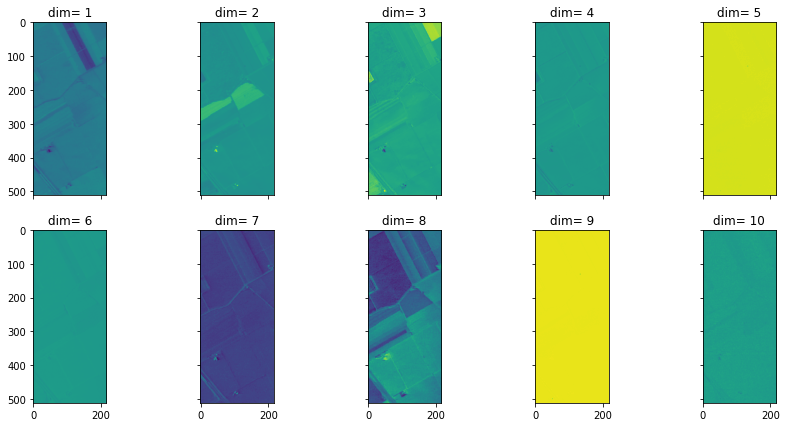

In [ ]:
fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(ICAbandFinalarray[:,:,numb])
    axe.set_title('dim='+' '+str(numb+1))

fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

In [ ]:
def padWithZeros(X, margin=2):    # Padding the image with zeroes and is dedendent on the window or patch size
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):  #creating image patches with window size.
    margin = int((windowSize - 1) / 2)
    print(margin)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    print(X.shape[0] * X.shape[1])
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

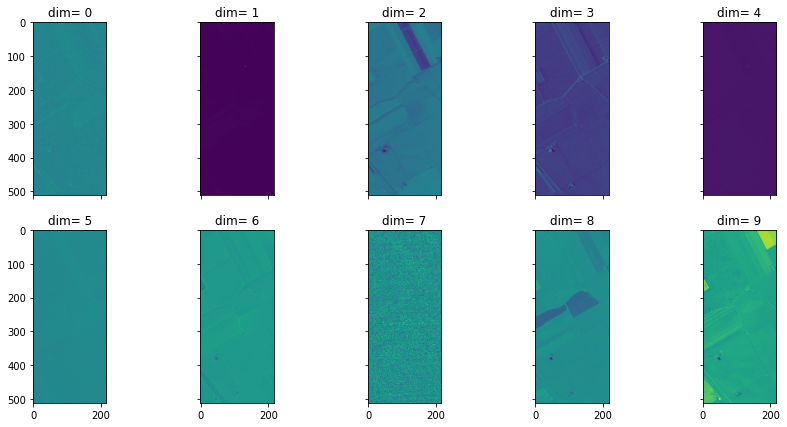

In [ ]:
fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(ICAbandFinalarray[:,:,numb])
    axe.set_title('dim='+' '+str(numb))

fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

In [ ]:
Feature_Image, Target = createImageCubes(ICAbandFinalarray, groundtruth, windowSize=27)
print(Feature_Image.shape)
print(Target.shape)

13
111104
(54129, 27, 27, 11)
(54129,)


In [ ]:
from sklearn.model_selection import train_test_split
trainsize=3
testsize= ((100-trainsize)/100)
print(testsize)
Feature_Image1,Target1 = shuffle(Feature_Image,Target)
x_train, x_test, y_train, y_test = train_test_split(Feature_Image1,Target1,test_size=testsize,stratify=Target1)
#x_train, x_test, y_train, y_test = train_test_split(Feature_Image,Target,test_size=testsize,stratify=Target)
YtrainFrame=pd.DataFrame(y_train,columns=['target'])
y=YtrainFrame['target']
z=y.value_counts(ascending=True)
yq=pd.DataFrame(z)
print("Final Training Samples ", yq )

0.97
Final Training Samples        target
12.0      28
10.0      32
13.0      32
3.0       42
15.0      54
11.0      58
2.0       59
0.0       60
4.0       80
9.0       98
6.0      107
1.0      112
5.0      119
8.0      186
14.0     218
7.0      338


In [ ]:
windowSize=27
K=bands   # Number of PCA bands
x_train = x_train.reshape(-1, windowSize, windowSize, K, 1)
x_train.shape

(1623, 27, 27, 11, 1)

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_train.shape

(1623, 16)

In [ ]:
x_test = x_test.reshape(-1, windowSize, windowSize, K, 1)
print(x_test.shape)
y_test=np_utils.to_categorical(y_test)
print(y_test.shape)

(52506, 27, 27, 11, 1)
(52506, 16)


In [ ]:
from tensorflow.keras import backend as A
def swish(x):
    return 1*(x * A.sigmoid(x))

In [ ]:
def mish(x):
    return x*A.tanh(A.softplus(x))

In [ ]:
model=Sequential()
model_swish=Sequential()

conv3D_1=Conv3D(32,(7,7,5),padding='valid',input_shape=(windowSize,windowSize,K,1))
conv3D_1r=conv3D_1
conv3D_1s=conv3D_1
model.add(conv3D_1r)
model.add(Activation('relu'))
model_swish.add(conv3D_1s)
model_swish.add(Activation(swish))

print(conv3D_1r.output_shape)
#print(conv3D_1s.output_shape)
conv3D_2=Conv3D(32,(3,3,3))
conv3D_2r=conv3D_2
conv3D_2s=conv3D_2
model.add(conv3D_2r)
model.add(Activation('relu'))
model_swish.add(conv3D_2s)
model_swish.add(Activation(swish))

#conv3D_3=(Conv3D(32,(3,3,3)))
#model.add(conv3D_3)
#model.add(Activation('relu'))
#model_swish.add(conv3D_3)
#model_swish.add(Activation(swish))
#model_mish.add(conv3D_3)
#model_mish.add(Activation(mish))
c=conv3D_2r.output_shape # Getting output shape of the layer
#c=conv3D_3.output_shape
print(c)
cs=conv3D_2s.output_shape # Getting output shape of the layer
#cs=conv3D_3.output_shape
print(c)
#model.add(Dropout(0.4))
#model_swish.add(Dropout(0.4))
reshape3D_4r = Reshape((c[1], c[2], c[3]*c[4])) # Reshape Layer for 3D to 2D
reshape3D_4s = Reshape((cs[1], cs[2], cs[3]*cs[4]))
model.add(reshape3D_4r)
model_swish.add(reshape3D_4s)

print(reshape3D_4r.output_shape)
#-----Convolution 2D Layer
conv2D_1=Conv2D(filters=32, kernel_size=(4,4))
conv2D_1s=conv2D_1
conv2D_1r=conv2D_1
model.add(conv2D_1s)
model.add(Activation('relu'))
model_swish.add(conv2D_1r)
model_swish.add(Activation(swish))

model.add(MaxPooling2D(pool_size=(2,2)))
model_swish.add(MaxPooling2D(pool_size=(2,2)))

conv2D_2=Conv2D(filters=64, kernel_size=(3,3))
conv2D_2r=conv2D_2
conv2D_2s=conv2D_2
model.add(conv2D_2r)
model.add(Activation('relu'))
model_swish.add(conv2D_2s)
model_swish.add(Activation(swish))
#model.add(BatchNormalization())
#model_swish.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model_swish.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.4))
#model_swish.add(Dropout(0.4))

model.add(Flatten())
model_swish.add(Flatten())

(None, 21, 21, 7, 32)
(None, 19, 19, 5, 32)
(None, 19, 19, 5, 32)
(None, 19, 19, 160)


In [ ]:

D1=Dense(units=256)
D2=Dense(units=128)
D1r=D1
D1s=D1
D2r=D2
D2s=D2
#D3=Dense(units=64)
#model.add(Dense(units=256,activation='relu'))
model.add(D1s)
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(D2r)
model.add(Activation('relu'))
model.add(Dropout(0.4))
#model.add(D3)
#model.add(Activation('relu'))
output_units=16  #category in indian pines
model.add(Dense(units=output_units, activation='softmax'))

model_swish.add(D1s)
model_swish.add(Activation(swish))
model_swish.add(Dropout(0.4))
model_swish.add(D2s)
model_swish.add(Activation(swish))
model_swish.add(Dropout(0.4))
#model_swish.add(D3)
#model_swish.add(Activation(swish))
output_units=16 #category in indian pines
model_swish.add(Dense(units=output_units, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 21, 21, 7, 32)     7872      
_________________________________________________________________
activation_12 (Activation)   (None, 21, 21, 7, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 5, 32)     27680     
_________________________________________________________________
activation_14 (Activation)   (None, 19, 19, 5, 32)     0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 19, 19, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        81952     
_________________________________________________________________
activation_16 (Activation)   (None, 16, 16, 32)       

In [ ]:
model_swish.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 21, 21, 7, 32)     7872      
_________________________________________________________________
activation_13 (Activation)   (None, 21, 21, 7, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 5, 32)     27680     
_________________________________________________________________
activation_15 (Activation)   (None, 19, 19, 5, 32)     0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 19, 19, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        81952     
_________________________________________________________________
activation_17 (Activation)   (None, 16, 16, 32)       

In [ ]:
Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model_swish.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=1)

In [ ]:

filepath = "bestmodel.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history=model.fit(x_train, y_train, batch_size=200, epochs=250, validation_split=0.0, verbose=1, callbacks=[tensorboard_callback,checkpoint])
#history=model.fit(x_train, y_train, batch_size=100, epochs=200, validation_split=0.0, verbose=1, callbacks=callbacks_list)

Epoch 1/250
1/9 [==>...........................] - ETA: 0s - loss: 2.7725 - accuracy: 0.0900WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - ETA: 0s - loss: 2.7046 - accuracy: 0.1719
Epoch 00001: loss improved from inf to 2.70456, saving model to bestmodel.hdf5
9/9 [==============================] - 0s 55ms/step - loss: 2.7046 - accuracy: 0.1719
Epoch 2/250
9/9 [==============================] - ETA: 0s - loss: 2.5373 - accuracy: 0.2039
Epoch 00002: loss improved from 2.70456 to 2.53728, saving model to bestmodel.hdf5
9/9 [==============================] - 0s 43ms/step - loss: 2.5373 - accuracy: 0.2039
Epoch 3/250
7/9 [======================>.......] - ETA: 0s - loss: 2.4086 - accuracy: 0.1943
Epoch 00003: loss improved fr

In [ ]:
model.load_weights("bestmodel.hdf5")               # loading weights from trained model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
y_pred= model.predict(x_test)
y_pred= np.argmax(y_pred, axis=1)
classification = classification_report(np.argmax(y_test, axis=1), y_pred)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1949
           1       1.00      1.00      1.00      3614
           2       1.00      1.00      1.00      1917
           3       0.99      1.00      0.99      1352
           4       0.99      0.99      0.99      2598
           5       1.00      1.00      1.00      3840
           6       1.00      1.00      1.00      3472
           7       1.00      1.00      1.00     10933
           8       1.00      1.00      1.00      6017
           9       1.00      0.98      0.99      3180
          10       0.96      1.00      0.98      1036
          11       0.99      1.00      0.99      1869
          12       1.00      0.98      0.99       888
          13       1.00      1.00      1.00      1038
          14       1.00      1.00      1.00      7050
          15       1.00      0.99      1.00      1753

    accuracy                           1.00     52506
   macro avg       1.00   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

1459/1459 [==============================] - 7s 5ms/step - loss: 0.0156 - accuracy: 0.9975
0.9974669561573916
0.997179514358398
0.9963595677323227
[1.         1.         1.         0.9853908  0.99306626 1.
 1.         0.99853855 0.99800962 1.         0.96014829 0.98732171
 1.         1.         1.         1.        ]


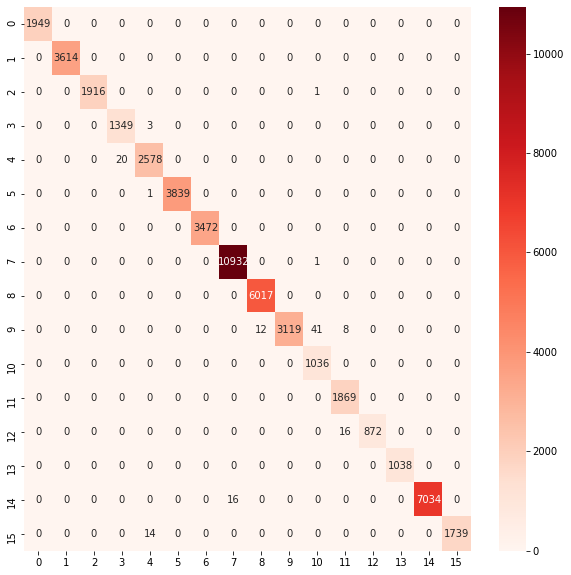

In [ ]:

oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
score = model.evaluate(x_test, y_test, batch_size=36)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100
print(oa)
print(kappa)
print(aa)
#print (confusion)
a=confusion.diagonal()/confusion.sum(axis=0)
print(a)

plt.figure(figsize=(10,10))
sn.heatmap(confusion, annot=True, cmap=plt.cm.Reds,fmt="d")
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers ]
print (layer_outputs)

[<tf.Tensor 'conv3d_2/BiasAdd:0' shape=(None, 21, 21, 7, 32) dtype=float32>, <tf.Tensor 'activation_12/Relu:0' shape=(None, 21, 21, 7, 32) dtype=float32>, <tf.Tensor 'conv3d_3/BiasAdd:0' shape=(None, 19, 19, 5, 32) dtype=float32>, <tf.Tensor 'activation_14/Relu:0' shape=(None, 19, 19, 5, 32) dtype=float32>, <tf.Tensor 'reshape_2/Reshape:0' shape=(None, 19, 19, 160) dtype=float32>, <tf.Tensor 'conv2d_2/BiasAdd:0' shape=(None, 16, 16, 32) dtype=float32>, <tf.Tensor 'activation_16/Relu:0' shape=(None, 16, 16, 32) dtype=float32>, <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 8, 8, 32) dtype=float32>, <tf.Tensor 'conv2d_3/BiasAdd:0' shape=(None, 6, 6, 64) dtype=float32>, <tf.Tensor 'activation_18/Relu:0' shape=(None, 6, 6, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_6/MaxPool:0' shape=(None, 3, 3, 64) dtype=float32>, <tf.Tensor 'flatten_2/Reshape:0' shape=(None, 576) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'activation_20/Relu:0' sh

In [ ]:
print(x_test[1].shape)
a=x_test[5].reshape(-1,27,27,11,1)
otest=x_test[5]

(27, 27, 11, 1)


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

height = groundtruth.shape[0]
width = groundtruth.shape[1]
PATCH_SIZE = 25
numComponents = K
X = padWithZeros(ICAbandFinalarray, PATCH_SIZE//2)

In [ ]:

filepath1 = "bestmodel_swish.hdf5"
checkpoint_swish = ModelCheckpoint(filepath1, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_s= [checkpoint_swish]

In [ ]:
  logdir = os.path.join("logs1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir='./logs1', histogram_freq=1)


In [ ]:
#history_swish=model_swish.fit(x_train, y_train, batch_size=200, epochs=250, validation_split=0.0, verbose=1, callbacks=[tensorboard_callback1,checkpoint_swish])
history_swish=model_swish.fit(x_train, y_train, batch_size=200, epochs=250, validation_split=0.0, verbose=1, callbacks=callbacks_list_s)

Epoch 1/250
9/9 [==============================] - ETA: 0s - loss: 4.3379 - accuracy: 0.2927
Epoch 00001: loss improved from inf to 4.33792, saving model to bestmodel_swish.hdf5
9/9 [==============================] - 0s 42ms/step - loss: 4.3379 - accuracy: 0.2927
Epoch 2/250
7/9 [======================>.......] - ETA: 0s - loss: 1.3452 - accuracy: 0.5707
Epoch 00002: loss improved from 4.33792 to 1.32519, saving model to bestmodel_swish.hdf5
9/9 [==============================] - 0s 39ms/step - loss: 1.3252 - accuracy: 0.5736
Epoch 3/250
7/9 [======================>.......] - ETA: 0s - loss: 0.8793 - accuracy: 0.7079
Epoch 00003: loss improved from 1.32519 to 0.85815, saving model to bestmodel_swish.hdf5
9/9 [==============================] - 0s 39ms/step - loss: 0.8581 - accuracy: 0.7166
Epoch 4/250
7/9 [======================>.......] - ETA: 0s - loss: 0.5833 - accuracy: 0.7993
Epoch 00004: loss improved from 0.85815 to 0.57863, saving model to bestmodel_swish.hdf5
9/9 [=============

In [ ]:
model.load_weights("bestmodel.hdf5")               # loading weights from trained model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
model_swish.load_weights("bestmodel_swish.hdf5")               # loading weights from trained model
model_swish.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
y_pred_swish= model_swish.predict(x_test)
y_pred_swish= np.argmax(y_pred_swish, axis=1)
classification = classification_report(np.argmax(y_test, axis=1), y_pred_swish)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1949
           1       1.00      1.00      1.00      3614
           2       1.00      1.00      1.00      1917
           3       0.99      1.00      0.99      1352
           4       0.99      0.99      0.99      2598
           5       1.00      1.00      1.00      3840
           6       1.00      1.00      1.00      3472
           7       1.00      0.99      0.99     10933
           8       1.00      1.00      1.00      6017
           9       1.00      0.99      0.99      3180
          10       0.97      1.00      0.99      1036
          11       1.00      0.99      1.00      1869
          12       0.98      1.00      0.99       888
          13       1.00      1.00      1.00      1038
          14       0.99      0.99      0.99      7050
          15       1.00      1.00      1.00      1753

    accuracy                           1.00     52506
   macro avg       0.99   

1459/1459 [==============================] - 8s 5ms/step - loss: 0.0193 - accuracy: 0.9959
0.9959433207633414
0.9954838306376366
0.9971900056225568
[1.         1.         0.9984375  0.98826119 0.99461331 1.
 1.         0.99778822 0.99933566 0.9984132  0.97094658 1.
 0.9833887  1.         0.98580464 1.        ]


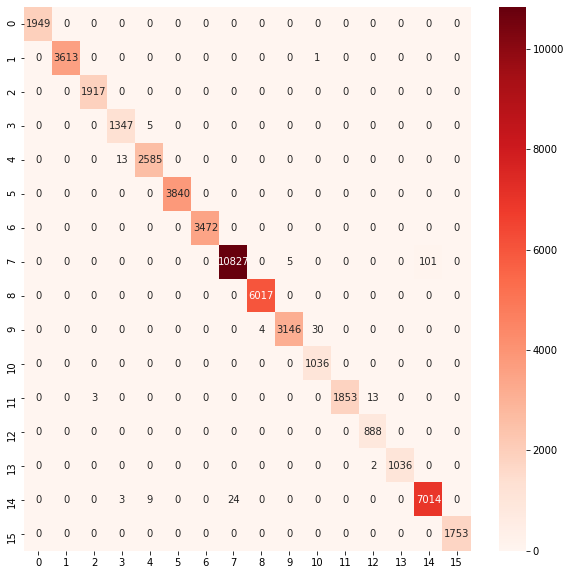

In [ ]:
oa_swish = accuracy_score(np.argmax(y_test, axis=1), y_pred_swish)
confusion_swish = confusion_matrix(np.argmax(y_test, axis=1), y_pred_swish)
each_acc, aa_swish = AA_andEachClassAccuracy(confusion_swish)
kappa_swish = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred_swish)
score_swish = model_swish.evaluate(x_test, y_test, batch_size=36)
Test_Loss_swish =  score_swish[0]*100
Test_accuracy_swish = score_swish[1]*100
print(oa_swish)
print(kappa_swish)
print(aa_swish)
#print (confusion)
a=confusion_swish.diagonal()/confusion_swish.sum(axis=0)
print(a)


plt.figure(figsize=(10,10))
sn.heatmap(confusion_swish, annot=True, cmap=plt.cm.Reds,fmt="d")
plt.show()

dict_keys(['loss', 'accuracy'])


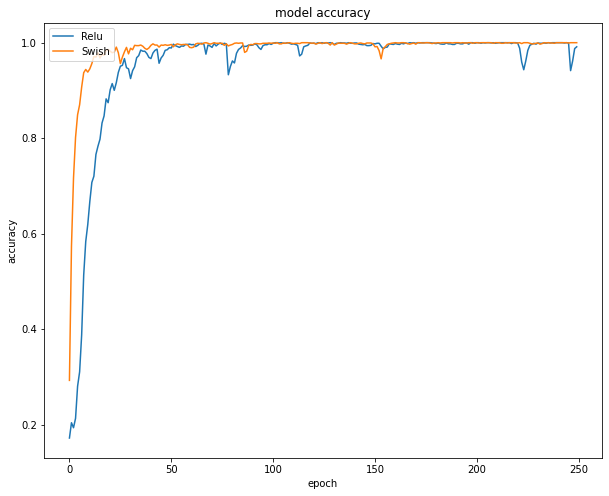

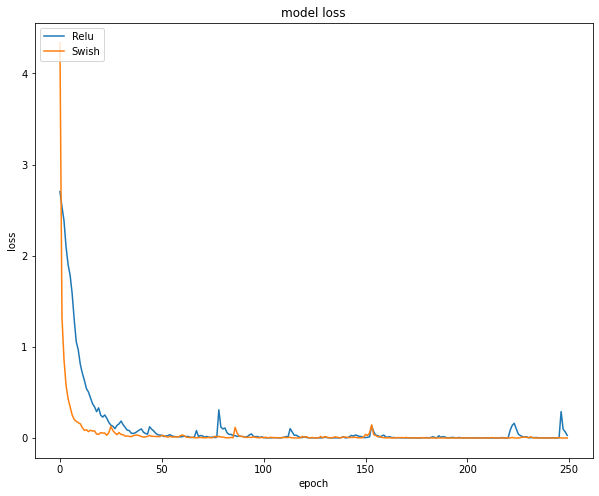

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history_swish.history['accuracy'])

#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Relu', 'Swish'], loc='upper left')
plt.show()
# "Loss"
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history_swish.history['loss'])

#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Relu', 'Swish'], loc='upper left')
plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

height = groundtruth.shape[0]
width = groundtruth.shape[1]
PATCH_SIZE = 27
numComponents = K
X = padWithZeros(ICAbandFinalarray, PATCH_SIZE//2)

In [ ]:
layer_outputs = [layer.output for layer in model_swish.layers ]
print (layer_outputs)

[<tf.Tensor 'conv3d_2/BiasAdd:0' shape=(None, 21, 21, 7, 32) dtype=float32>, <tf.Tensor 'activation_13/mul_1:0' shape=(None, 21, 21, 7, 32) dtype=float32>, <tf.Tensor 'conv3d_3/BiasAdd:0' shape=(None, 19, 19, 5, 32) dtype=float32>, <tf.Tensor 'activation_15/mul_1:0' shape=(None, 19, 19, 5, 32) dtype=float32>, <tf.Tensor 'reshape_3/Reshape:0' shape=(None, 19, 19, 160) dtype=float32>, <tf.Tensor 'conv2d_2/BiasAdd:0' shape=(None, 16, 16, 32) dtype=float32>, <tf.Tensor 'activation_17/mul_1:0' shape=(None, 16, 16, 32) dtype=float32>, <tf.Tensor 'max_pooling2d_5/MaxPool:0' shape=(None, 8, 8, 32) dtype=float32>, <tf.Tensor 'conv2d_3/BiasAdd:0' shape=(None, 6, 6, 64) dtype=float32>, <tf.Tensor 'activation_19/mul_1:0' shape=(None, 6, 6, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_7/MaxPool:0' shape=(None, 3, 3, 64) dtype=float32>, <tf.Tensor 'flatten_3/Reshape:0' shape=(None, 576) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'activation_22/mul_1:

In [ ]:
b=x_test[5].reshape(-1,27,27,11,1)

In [ ]:
featuremap1=actmodel1.predict(b)
print (featuremap1.shape)

In [ ]:
print ('Original Image')
spectral.imshow(otest[:,:,:,0],(8,10,10))
b=featuremap1.reshape(21,21,16,32)
for i in range(32):
  select=b[:,:,:,i]
  spectral.imshow(select,(8,10,10),figsize=(1.5,1.5),fignum=i)